# Analyse de la db ``media_analysis``

### Importation des bibliothèques et de leurs packages

In [1]:
# Fonctions 'bash'
import os
from pathlib import Path

# Connexion à la base de données Mongo
import pymongo
from pymongo import MongoClient, ASCENDING, DESCENDING

# Collecte des données et écriture
import json
from bson import json_util, ObjectId

from collections import defaultdict
import string

# Mise en forme du texte python
from pprint import pprint

# Gestion des formats 'date'
from datetime import datetime, date, time, timedelta
from matplotlib.dates import DateFormatter

# Visualisation des données
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd


ModuleNotFoundError: No module named 'pymongo'

### Connexion à la base de données

In [2]:
host = "ec2-15-188-255-64.eu-west-3.compute.amazonaws.com" 
port = 27017
username = "semal"
password = "$hMN3PU]V][xR]zn"

mongo_client = MongoClient(host=host, port=port, username=username, password=password)

db = mongo_client["media_analysis"]["articles"]

### Analyse du nombre de documents dans la base de données

#### Nombre total d'articles

In [3]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents
documents_count = db.count_documents({})
print(f"La base de données comprend {documents_count} articles.")

Date d'exécution de la requête : 2024-05-15
La base de données comprend 3655311 articles.


#### Nombre d'articles francophones

In [4]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents publiés en français
french_count = db.count_documents({"meta.source.language": "fr"})
print(f"Le nombre d'articles francophones s'élève à {french_count}.")

Date d'exécution de la requête : 2024-05-15
Le nombre d'articles francophones s'élève à 2018191.


### Analyse du champ ``meta``

#### Nombre de champs ``meta`` absents

In [5]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "meta" est absent
no_meta_count = db.count_documents({"meta": {"$exists": False}})
print(f"Nombre de champs 'meta' absents: {no_meta_count}.")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'meta' absents: 0.


Tous les articles possèdent un champ ``meta``. Nous pouvons nous servir de ce champs pour sélectionner les articles dont la langue source est ``fr``.

### Analyse du champ ``date``

#### Nombre de champs ``date`` absents

In [6]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "date" est absent
no_date_count = db.count_documents({
    "$and": [
        {"date": {"$exists": False}}, 
        {"meta.source.language": "fr"}
    ]
})
print(f"Nombre de champs 'date' manquant dans nos articles francophones : {no_date_count}")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'date' manquant dans nos articles francophones : 0


### Analyse du champ ``text`` 

#### Nombre de champs ``text`` absents

In [7]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "text" est absent
no_text_count = db.count_documents({
    "$and": [
        {"text": {"$exists": False}}, 
        {"meta.source.language": "fr"}]
})
print(f"Nombre de champs 'text' manquants dans nos articles francophones : {no_text_count}")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'text' manquants dans nos articles francophones : 9652


#### Intervalle de temps sans champ ``text``

In [8]:
pipeline = [
    {
        "$match": {
            "text": {"$exists": False}, 
            "meta.source.language": "fr"}
    },
    {"$group": {
        "_id": None, 
        "minDate": {"$min": "$date"}, 
        "maxDate": {"$max": "$date"}
    }}
]

result = list(db.aggregate(pipeline))

min_date = result[0]["minDate"]
max_date = result[0]["maxDate"]

print("Fourchette de dates pour les textes manquants :")
print("====================")
print(f"Date minimale: {min_date.date()}")
print(f"Date maximale: {max_date.date()}")

Fourchette de dates pour les textes manquants :
Date minimale: 2020-05-19
Date maximale: 2024-05-14


#### Nombre de textes manquants par date et par source

In [9]:
# Nombre d'articles par date et par source dont le texte est absent
missing_text_by_date_and_source = []
current_date = min_date

while current_date <= max_date:
    next_date = current_date + timedelta(days=1)
    query = {
        "date": {"$gte": current_date, "$lt": next_date},
        "text": {"$exists": False},
        "meta.source.language": "fr"
    }
    pipeline = [
        {"$match": query},
        {"$group": {
            "_id": {
                "date": current_date, 
                "source": "$meta.source.name"}, 
            "count": {"$sum": 1}}},
        {"$project": {
            "_id": 0,
            "date": "$_id.date",
            "source": "$_id.source",
            "count": "$count"
        }}
    ]
    result = list(db.aggregate(pipeline))
    missing_text_by_date_and_source.extend(result)
    current_date += timedelta(days=1)

print("Nombre d'articles par date et par source dont le texte est absent :")
print("====================")
for item in missing_text_by_date_and_source:
    print(f"Date: {item['date'].date()}, Source: {item['source']}, Occurence(s): {item['count']}")
    

Nombre d'articles par date et par source dont le texte est absent :
Date: 2020-05-19, Source: levif.be, Occurence(s): 3
Date: 2020-05-20, Source: levif.be, Occurence(s): 5
Date: 2020-05-21, Source: levif.be, Occurence(s): 6
Date: 2020-05-22, Source: levif.be, Occurence(s): 3
Date: 2020-05-22, Source: rtlinfo.be, Occurence(s): 1
Date: 2020-05-22, Source: lalibre.be, Occurence(s): 4
Date: 2020-05-22, Source: lesoir.be, Occurence(s): 2
Date: 2020-05-22, Source: rtbf.be, Occurence(s): 4
Date: 2020-05-22, Source: dhnet.be, Occurence(s): 3
Date: 2020-05-22, Source: lavenir.net, Occurence(s): 1
Date: 2020-05-23, Source: levif.be, Occurence(s): 6
Date: 2020-05-23, Source: lalibre.be, Occurence(s): 1
Date: 2020-05-23, Source: dhnet.be, Occurence(s): 1
Date: 2020-05-23, Source: sudinfo.be, Occurence(s): 1
Date: 2020-05-23, Source: rtbf.be, Occurence(s): 2
Date: 2020-05-23, Source: lesoir.be, Occurence(s): 4
Date: 2020-05-24, Source: sudinfo.be, Occurence(s): 1
Date: 2020-05-24, Source: lalibre.b

#### Histogramme du nombre de textes manquants

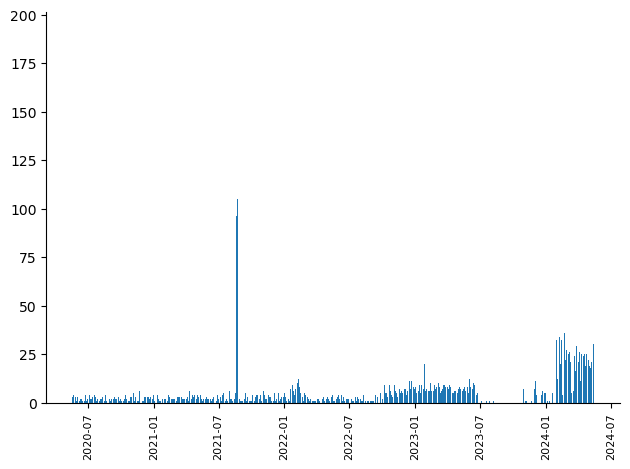

In [10]:
# Extraction des données
dates = [item["date"].date() for item in missing_text_by_date_and_source]
counts = [item["count"] for item in missing_text_by_date_and_source]

# Création de l'histogramme
fig, ax = plt.subplots()
ax.bar(dates, counts)

# Formattage des dates sur l'axe x
ax.xaxis.set_tick_params(rotation=45)

# Modifier l'axe des abscisses
ax.tick_params(axis='x', labelsize=8, labelrotation=90) 

# Labels et titre du graphique
# ax.set_xlabel("Date")
# ax.set_ylabel("Nombre de textes manquants")
# ax.set_title("Évolution du nombre de textes manquants par mois et par année")

# Affichage du graphique
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()

# Sauvegarder le graphique dans le dossier local ".\data\plots"
if not os.path.exists(f"./data/plots"):
                os.makedirs(f"./data/plots")
        
output_path = "./data/plots/Dristribution du nombre de textes manquants.png"
plt.savefig(output_path)

plt.show()

plt.close()

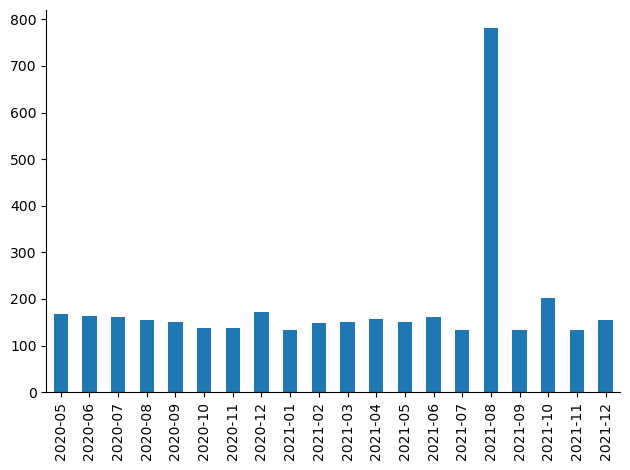

In [11]:
# Extraction des données
dates = [item["date"].date() for item in missing_text_by_date_and_source]
counts = [item["count"] for item in missing_text_by_date_and_source]

# Création d'un DataFrame pandas à partir des données
data = pd.DataFrame({'Date': pd.to_datetime(dates), 'Nombre de textes manquants': counts})

# Filtrage des données pour la plage de juin 2020 à septembre 2021
start_date = pd.to_datetime('2020-05-01')
end_date = pd.to_datetime('2021-12-31')
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Grouper les données par mois et sommer les valeurs par jour
grouped_data = filtered_data.groupby(filtered_data['Date'].dt.to_period('M')).sum(numeric_only=True)

# Affichage du graphique de l'évolution du nombre de textes manquants par mois
fig, ax = plt.subplots()
grouped_data.plot(kind='bar', ax=ax, legend=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=90)
plt.tight_layout()

# Sauvegarder le graphique dans le dossier local ".\data\plots"
output_path = "./data/plots/Evolution du nombre de textes manquants par mois de mai 2020 à fin 2021.png"
plt.savefig(output_path)

plt.show()


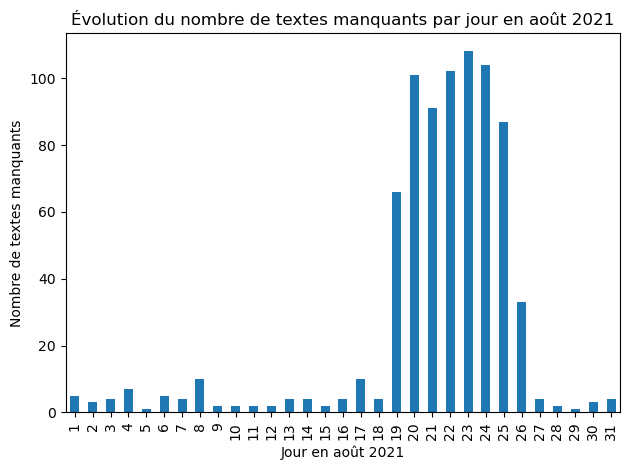

In [12]:
# Extraction des données
dates = [item["date"].date() for item in missing_text_by_date_and_source]
counts = [item["count"] for item in missing_text_by_date_and_source]

# Création d'un DataFrame pandas à partir des données
data = pd.DataFrame({'Date': pd.to_datetime(dates), 'Nombre de textes manquants': counts})

# Filtrage des données pour le mois d'août 2021
start_date = pd.to_datetime('2021-08-01')
end_date = pd.to_datetime('2021-08-31')
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Grouper les données par jour et sommer les valeurs par jour
grouped_data = filtered_data.groupby(filtered_data['Date'].dt.day).sum(numeric_only=True)

# Affichage du graphique de l'évolution du nombre de textes manquants par jour en août 2021
fig, ax = plt.subplots()
grouped_data.plot(kind='bar', ax=ax, legend=False)
ax.set_xlabel("Jour en août 2021")
ax.set_ylabel("Nombre de textes manquants")
ax.set_title("Évolution du nombre de textes manquants par jour en août 2021")

# Formattage des étiquettes de l'axe des x pour afficher une date simplifiée
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x+1)))  # Format des jours sans zéro initial
plt.xticks(rotation=90)
plt.tight_layout()

# Sauvegarder le graphique dans le dossier local ".\data\plots"
output_path = "./data/plots/Evolution du nombre de textes manquants par jour en aout_2021.png"
plt.savefig(output_path)

plt.show()


In [13]:
# Extraction des données
dates = [item["date"].date() for item in missing_text_by_date_and_source]
counts = [item["count"] for item in missing_text_by_date_and_source]

# Création d'un DataFrame pandas à partir des données
data = pd.DataFrame({'Date': pd.to_datetime(dates), 'Nombre de textes manquants': counts})

# Création du répertoire de sortie s'il n'existe pas déjà
output_directory = "./data/plots/textes_manquants_par_mois"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Créer une liste distincte pour les dates "MM-AAAA" à afficher sur l'axe des x
date_labels = data['Date'].dt.strftime('%m-%Y').unique()

# Filtrer et générer des graphiques par mois
for date_label in date_labels:
    # Convertir le label de date "MM-AAAA" en objet datetime pour le filtrage
    start_date = pd.to_datetime(f'01-{date_label}', format='%d-%m-%Y')
    end_date = pd.to_datetime(f'{pd.Timestamp(start_date).days_in_month}-{date_label}', format='%d-%m-%Y')
    
    # Filtrage des données pour le mois en cours
    filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    if not filtered_data.empty:
        # Grouper les données par jour et sommer les valeurs par jour
        grouped_data = filtered_data.groupby(filtered_data['Date']).sum()

        # Créer un graphique pour le mois en cours
        fig, ax = plt.subplots()
        grouped_data.plot(kind='bar', ax=ax, legend=False)
        ax.set_xlabel(f"Jour en {date_label}")
        ax.set_ylabel("Nombre de textes manquants")
        ax.set_title(f"Évolution du nombre de textes manquants par jour en {date_label}")

        # Formattage des étiquettes de l'axe des x pour afficher une date simplifiée
        date_format = DateFormatter("%d-%m")  # Format de date personnalisé
        ax.xaxis.set_major_formatter(date_format)
        plt.xticks(rotation=90)
        plt.tight_layout()

        # Sauvegarder le graphique dans le dossier local avec identification du mois
        output_filename = f"{date_label}_textes_manquants.png"
        output_path = os.path.join(output_directory, output_filename)
        plt.savefig(output_path)

        plt.close()

# Affichage de tous les graphiques créés
print("Graphiques sauvegardés avec succès.")


Graphiques sauvegardés avec succès.


#### Nombre de textes manquants par source et par feed

In [14]:
# Nombre d'articles par source et par titre du feed dont le texte est absent
missing_text_by_source_and_feed = []

query = {
    "text": {"$exists": False},
    "meta.source.language": "fr"
}

pipeline = [
    {"$match": query},
    {"$group": {
        "_id": {
            "source": "$meta.source.name",
            "feed": "$meta.source.feed_title",
        },
        "count": {"$sum": 1}
    }},
    {"$project": {
        "_id": 0,
        "source": "$_id.source",
        "feed": "$_id.feed",
        "count": "$count"
    }}
]

result = list(db.aggregate(pipeline))
missing_text_by_source_and_feed.extend(result)

print("Nombre d'articles par source et par feed dont le texte est absent :")
print("====================")
for item in sorted(missing_text_by_source_and_feed, key=lambda x: (x["source"], x["feed"])):
    print(f"Source: {item['source']}, Feed: {item['feed']}, Count: {item['count']}")

Nombre d'articles par source et par feed dont le texte est absent :
Source: dhnet.be, Feed: Actu, Count: 192
Source: dhnet.be, Feed: Anderlecht, Count: 1
Source: dhnet.be, Feed: Auto-moto, Count: 2
Source: dhnet.be, Feed: Autres Sports, Count: 6
Source: dhnet.be, Feed: Basket, Count: 2
Source: dhnet.be, Feed: Belgique, Count: 69
Source: dhnet.be, Feed: Brabant wallon, Count: 1
Source: dhnet.be, Feed: Bruxelles, Count: 2
Source: dhnet.be, Feed: Centre, Count: 1
Source: dhnet.be, Feed: Charleroi, Count: 1
Source: dhnet.be, Feed: Cinéma, Count: 1
Source: dhnet.be, Feed: Conso, Count: 5
Source: dhnet.be, Feed: Cyclisme, Count: 2
Source: dhnet.be, Feed: Division 1A, Count: 1
Source: dhnet.be, Feed: Economie, Count: 1
Source: dhnet.be, Feed: Edito, Count: 1
Source: dhnet.be, Feed: Euro 2020, Count: 1
Source: dhnet.be, Feed: Europe, Count: 2
Source: dhnet.be, Feed: Faits divers, Count: 7
Source: dhnet.be, Feed: Football, Count: 30
Source: dhnet.be, Feed: General, Count: 90
Source: dhnet.be, F

In [15]:
# Nombre d'articles par source et par url du feed dont le texte est absent
missing_text_by_source_and_feed = []

query = {
    "text": {"$exists": False},
    "meta.source.language": "fr"
}

pipeline = [
    {"$match": query},
    {"$group": {
        "_id": {
            "source": "$meta.source.name",
            "feed": "$meta.source.feed_url",
        },
        "count": {"$sum": 1}
    }},
    {"$project": {
        "_id": 0,
        "source": "$_id.source",
        "feed_url": "$_id.feed",
        "count": "$count"
    }}
]

result = list(db.aggregate(pipeline))
missing_text_by_source_and_feed.extend(result)

print("Nombre d'articles par source et par feed dont le texte est absent :")
print("====================")
for item in sorted(missing_text_by_source_and_feed, key=lambda x: (x["source"], x["feed_url"])):
    print(f"Source: {item['source']}, Feed: {item['feed_url']}, Count: {item['count']}")

Nombre d'articles par source et par feed dont le texte est absent :
Source: dhnet.be, Feed: https://dhnet.be/rss.xml, Count: 149
Source: dhnet.be, Feed: https://dhnet.be/rss/dossiers.xml, Count: 3
Source: dhnet.be, Feed: https://dhnet.be/rss/infos.xml, Count: 20
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu.xml, Count: 192
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/belgique.xml, Count: 69
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/economie.xml, Count: 1
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/edito.xml, Count: 1
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/faits.xml, Count: 7
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/monde.xml, Count: 24
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/sante.xml, Count: 1
Source: dhnet.be, Feed: https://dhnet.be/rss/section/actu/societe.xml, Count: 7
Source: dhnet.be, Feed: https://dhnet.be/rss/section/conso.xml, Count: 5
Source: dhnet.be, Feed: https://dh

La distribution du nombre de textes manquants est distribuée à travers la plupart des feeds.

#### Nombre d'articles par source et par feed

In [16]:
# Nombre d'articles par source et par feed dont le texte est présent
feed_by_source = []

query = {
    "text": {"$exists": True},
    "meta.source.language": "fr"
}

pipeline = [
    {"$match": query},
    {"$group": {
        "_id": {
            "source": "$meta.source.name",
            "feed": "$meta.source.feed_title",
        },
        "count": {"$sum": 1}
    }},
    {"$project": {
        "_id": 0,
        "source": "$_id.source",
        "feed": "$_id.feed",
        "count": "$count"
    }}
]

result = list(db.aggregate(pipeline))
feed_by_source.extend(result)

In [17]:
print("Nombre d'articles par source et par feed avec texte :")
print("====================")
for item in sorted(feed_by_source, key=lambda x: (x["source"], x["feed"])):
    print(f"Source: {item['source']}, Feed: {item['feed']}, Count: {item['count']}")

Nombre d'articles par source et par feed avec texte :
Source: dhnet.be, Feed: Actu, Count: 16314
Source: dhnet.be, Feed: Alejandro Valverde, Count: 1
Source: dhnet.be, Feed: Anderlecht, Count: 189
Source: dhnet.be, Feed: Animaux, Count: 8
Source: dhnet.be, Feed: Argent, Count: 44
Source: dhnet.be, Feed: Assises Hainaut: Johnny Falise (49 ans) et Francine Genicot (54 ans) accusés du meurtre de Jacques Hubinon (75 ans) pour voler sa retraite, Count: 7
Source: dhnet.be, Feed: Auto-moto, Count: 388
Source: dhnet.be, Feed: Autres Sports, Count: 2543
Source: dhnet.be, Feed: Basket, Count: 726
Source: dhnet.be, Feed: Batibouw 2021 : comment évolue la maison, au centre de nos vies depuis un an ?, Count: 2
Source: dhnet.be, Feed: Beauté & Mode, Count: 13
Source: dhnet.be, Feed: Belgique, Count: 6428
Source: dhnet.be, Feed: Brabant wallon, Count: 4404
Source: dhnet.be, Feed: Bruxelles, Count: 5879
Source: dhnet.be, Feed: Budget, Count: 21
Source: dhnet.be, Feed: Buzz, Count: 66
Source: dhnet.be,

### Analyse du champ ``title``

#### Nombre de champs ``title`` absents

In [18]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "title" est absent
no_title_count = db.count_documents({
    "$and": [
        {"title": {"$exists": False}}, 
        {"meta.source.language": "fr"}
    ]})
print(f"Nombre de champs 'title' manquant dans nos articles francophones: {no_title_count}")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'title' manquant dans nos articles francophones: 3


Étant donné qu'il manque peu de titres, nous pouvons visualiser facilement les données correspondantes.

#### Affichage des documents dont ``title``est absent

In [19]:
# Récupérez les documents sans titre
documents = db.find({"title": {"$exists": False}})

# Affichez les documents récupérés
for document in documents:
    pprint(document)
    print("====================\n")

{'_id': ObjectId('5ec8cdec641dcd7d5c196858'),
 'date': datetime.datetime(2020, 5, 22, 13, 56, 31),
 'meta': {'feedparser': {'published_parsed': datetime.datetime(2020, 5, 22, 13, 56, 31),
                         'summary': "L'Art c'est comme la politique, ce n’est "
                                    "pas parce qu'on n'y connaît rien qu'on ne "
                                    'peut pas en parler. Alex Vizorek en a...',
                         'title': 'Alex Vizorek est une dernière fois une '
                                  "oeuvre d'art ce jeudi 28 mai sur La Deux"},
          'source': {'country': 'BE',
                     'feed_title': 'Général',
                     'feed_url': 'http://rss.rtbf.be/article/rss/rtbf_flux.xml',
                     'language': 'fr',
                     'name': 'rtbf.be'}},
 'url': 'https://www.rtbf.be/tv/emission/detail_humour/actualites/article_alex-vizorek-est-une-derniere-fois-une-oeuvre-d-art-ce-jeudi-28-mai-sur-la-deux?id=10507141&emis

Remarquons que les champs ``meta.feedparser.title`` comporte des données que nous pouvons exploiter. Aussi, ``meta.feedparser.summary`` comprend du texte !

### Analyse du champ ``textrazor_response``

In [20]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "textrazor_response" est présent
textrazor_count = db.count_documents({
    "$and": [
        {"textrazor_response": {"$exists": True}}, 
        {"meta.source.language": "fr"}
    ]})
print(f"Nombre de champs 'textrazor_response' présents dans nos articles francophones: {textrazor_count}")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'textrazor_response' présents dans nos articles francophones: 705164


#### Nombre de champs ``textrazor_response`` absents

In [21]:
now = datetime.now()
execution_date = now.date()
print(f"Date d'exécution de la requête : {execution_date}")
print("====================")

# Obtenir le nombre de documents dont le champ "textrazor_response" est absent
no_textrazor_count = db.count_documents({
    "$and": [
        {"textrazor_response": {"$exists": False}}, 
        {"meta.source.language": "fr"}]})
print(f"Nombre de champs 'textrazor_response' manquant dans nos articles francophones: {no_textrazor_count}")

Date d'exécution de la requête : 2024-05-15
Nombre de champs 'textrazor_response' manquant dans nos articles francophones: 1313027


#### Intervalle de temps couvert par ``textrazor_response``

In [22]:
# Obtenir les dates et les champs Textrazor correspondants
pipeline = [
    {"$match": {
        "$and": [
            {"meta.source.language": "fr"}, 
            {"textrazor_response": {"$exists": True}}
        ]
    }},
    {"$group": {
        "_id": None, 
        "minDate": {"$min": "$date"}, 
        "maxDate": {"$max": "$date"}}
    }
]

result = list(db.aggregate(pipeline))

min_date = result[0]["minDate"]
max_date = result[0]["maxDate"]

print("Fourchette des dates analysées par Textrazor:")
print("====================")
print(f"Date minimale: {min_date.date()}")
print(f"Date maximale: {max_date.date()}")

Fourchette des dates analysées par Textrazor:
Date minimale: 2020-05-01
Date maximale: 2021-09-23


#### Proportion de champs ``textrazor_response`` absents sur la période analysée

In [23]:
# Vérifier si des documents non analysés par Textrazor existent dans la fourchette de dates
no_textrazor_periode_count = db.count_documents({
    "$and": [
        {"date": {"$gte": min_date, "$lte": max_date}}, 
        {"meta.source.language": "fr"}, 
        {"textrazor_response": {"$exists": False}}
    ]})

In [24]:
print(f"Il manque {no_textrazor_periode_count} articles analysés par Textrazor sur la période analysée.")
print("====================")

# Pourcentage de champs manquants Textrazor par rapport au nombre total d'articles capturés sur le même temps

print(f"Cela représente une proportion de {no_textrazor_periode_count / (no_textrazor_periode_count + textrazor_count):.2%} du corpus francophone analysé pour les mêmes dates.")


Il manque 96840 articles analysés par Textrazor sur la période analysée.
Cela représente une proportion de 12.07% du corpus francophone analysé pour les mêmes dates.


#### Distribution des textes analysés par Textrazor par mois

In [25]:
# Fixer une plage de date qui inclut les dates de l'intervalle calculé plus haut
min_date = datetime(2020, 5, 1).date()
max_date = datetime(2021, 9, 30).date()  

# Créer une liste pour stocker les données de distribution
data = []

# Initialiser les sommes par colonne
total_missing_textrazor = 0
total_present_textrazor = 0

# Parcourir la plage de dates mensuelles
for start_date, end_date in zip(pd.date_range(start=min_date, end=max_date, freq='MS'),
                                pd.date_range(start=min_date, end=max_date, freq='M')):

    # Compter le nombre de textes manquants et présents dans cet intervalle de temps
    missing_textrazor_count = db.count_documents({
        "date": {"$gte": start_date, "$lt": end_date + pd.Timedelta(days=1)},  # Ajouter 1 jour pour inclure la fin du mois
        "meta.source.language": "fr",
        "textrazor_response": {"$exists": False}
    })
    present_textrazor_count = db.count_documents({
        "date": {"$gte": start_date, "$lt": end_date + pd.Timedelta(days=1)},  # Ajouter 1 jour pour inclure la fin du mois
        "meta.source.language": "fr",
        "textrazor_response": {"$exists": True}
    })
    
    # Ajouter les données à la liste
    data.append({
        'Mois': start_date.strftime('%Y-%m'),
        'Champs Textrazor manquants': missing_textrazor_count,
        'Champs Textrazor présents': present_textrazor_count
    })
    
    # Mettre à jour les sommes par colonne
    total_missing_textrazor += missing_textrazor_count
    total_present_textrazor += present_textrazor_count

# Créer un DataFrame à partir des données
distribution_df = pd.DataFrame(data)

# Ajouter une ligne pour les sommes par colonne
total_row = {
    'Mois': 'Total',
    'Champs Textrazor manquants': total_missing_textrazor,
    'Champs Textrazor présents': total_present_textrazor
}

print("Distribution des Champs Textrazor par mois :")
print("====================")
print(distribution_df)


Distribution des Champs Textrazor par mois :
       Mois  Champs Textrazor manquants  Champs Textrazor présents
0   2020-05                         169                      19866
1   2020-06                         164                      48511
2   2020-07                         167                      48071
3   2020-08                         159                      47215
4   2020-09                         157                      53290
5   2020-10                         139                      53712
6   2020-11                         139                      46975
7   2020-12                         173                      47851
8   2021-01                         135                      51036
9   2021-02                         152                      47668
10  2021-03                         154                      53927
11  2021-04                         171                      46764
12  2021-05                         174                      50355
13  2021-06      

Grâce au détail de la distribution des textes bel et bien analysés par Textrazor, nous pouvons délimiter notre échantillon d'articles à extraire du 1er juin 2020 au 30 juin 2021 afin de garder un échantillon équilibré.

### Analyse des distributions du nombre d'articles

Étant donné que le reccueil des données débute en mai, je désire avoir une idée claire de la date à laquelle débute réellement le reccueil systématique.

In [26]:
# Sélection d'une date au format 'datetime'
start_date = datetime(2020, 5, 1)
end_date = datetime(2021, 9, 24)

# Pipeline de recherche pour la distribution du nombre d'articles
pipeline = [
    {"$match": {
        "date": {"$gte": start_date, "$lt": end_date},
        "meta.source.language": "fr"
    }},
    {"$group": {
        "_id": {"$dateToString": {"format": "%Y-%m-%d", "date": "$date"}}, 
        "count": {"$sum": 1}}},
    {"$sort": {
        "_id": 1}}
]

result = list(db.aggregate(pipeline))

In [27]:
print("Distribution du nombre d'articles pour l'intervalle considéré :")
print("====================")
for entry in result:
    date = entry["_id"]
    count = entry["count"]
    print(f"{date}: {count} articles")

Distribution du nombre d'articles pour l'intervalle considéré :
2020-05-01: 85 articles
2020-05-02: 93 articles
2020-05-03: 67 articles
2020-05-04: 138 articles
2020-05-05: 166 articles
2020-05-06: 185 articles
2020-05-07: 191 articles
2020-05-08: 202 articles
2020-05-09: 111 articles
2020-05-10: 98 articles
2020-05-11: 217 articles
2020-05-12: 268 articles
2020-05-13: 271 articles
2020-05-14: 369 articles
2020-05-15: 409 articles
2020-05-16: 240 articles
2020-05-17: 249 articles
2020-05-18: 531 articles
2020-05-19: 719 articles
2020-05-20: 894 articles
2020-05-21: 699 articles
2020-05-22: 1465 articles
2020-05-23: 926 articles
2020-05-24: 850 articles
2020-05-25: 1600 articles
2020-05-26: 1698 articles
2020-05-27: 1730 articles
2020-05-28: 1829 articles
2020-05-29: 1745 articles
2020-05-30: 1109 articles
2020-05-31: 881 articles
2020-06-01: 1026 articles
2020-06-02: 1613 articles
2020-06-03: 1726 articles
2020-06-04: 1766 articles
2020-06-05: 1902 articles
2020-06-06: 1187 articles
20

#### Calcul du nombre de données 'aberrantes'

Plusieurs anomalies apparaissent en début de liste, où nous constatons la présence de plusieurs documents entre 2006 et 2020. Il semble que les données commencent à être récoltées de manière systématique à partir du 20 mai 2020.

In [28]:
pipeline_outliers = [
    {
        "$match": {
            "meta.source.language": "fr", 
            "date": {"$lt": datetime(2020,5,1)}
        }
    },
    {
        "$group": {
            "_id": {"$year": "$date"}, 
            "count": {"$sum": 1}
        }
    }
]

result = list(db.aggregate(pipeline_outliers))

In [29]:
result_sorted = sorted(result, key=lambda x: x["_id"])
print(f"Nombre d'articles antérieurs au 1 mai 2020")
print("====================")
pprint(result_sorted)
pprint(result)

Nombre d'articles antérieurs au 1 mai 2020
[{'_id': 2006, 'count': 2},
 {'_id': 2007, 'count': 1},
 {'_id': 2011, 'count': 2},
 {'_id': 2012, 'count': 1},
 {'_id': 2013, 'count': 4},
 {'_id': 2014, 'count': 5},
 {'_id': 2015, 'count': 2},
 {'_id': 2016, 'count': 2},
 {'_id': 2017, 'count': 16},
 {'_id': 2018, 'count': 18},
 {'_id': 2019, 'count': 35},
 {'_id': 2020, 'count': 9}]
[{'_id': 2006, 'count': 2},
 {'_id': 2012, 'count': 1},
 {'_id': 2011, 'count': 2},
 {'_id': 2013, 'count': 4},
 {'_id': 2014, 'count': 5},
 {'_id': 2015, 'count': 2},
 {'_id': 2016, 'count': 2},
 {'_id': 2017, 'count': 16},
 {'_id': 2018, 'count': 18},
 {'_id': 2019, 'count': 35},
 {'_id': 2020, 'count': 9},
 {'_id': 2007, 'count': 1}]


#### Distribution du nombre d'articles extraits par année

In [30]:
%%time

pipeline_years = [
    {
        "$match": {
            "meta.source.language": "fr",
            "date": {"$gte": datetime(2020,5,1)}
        }
    },
    {
        "$group": {
            "_id": {"$year": "$date"}, 
            "count": {"$sum": 1}
        }
    }
]

results_years = list(db.aggregate(pipeline_years))

CPU times: total: 0 ns
Wall time: 6.9 s


In [31]:
results_years_sorted = sorted(results_years, key=lambda x: x["_id"])
pprint(results_years_sorted)

[{'_id': 2020, 'count': 366758},
 {'_id': 2021, 'count': 571258},
 {'_id': 2022, 'count': 442942},
 {'_id': 2023, 'count': 475730},
 {'_id': 2024, 'count': 161406}]


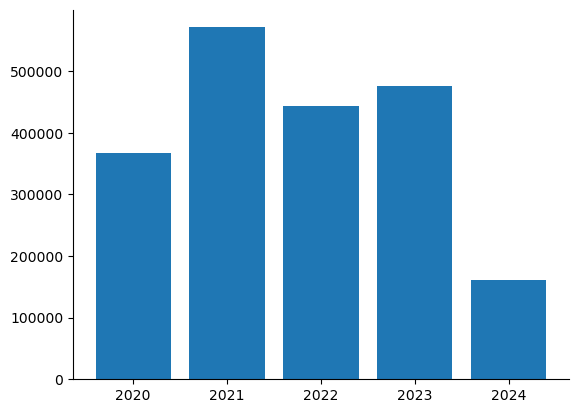

In [32]:
# Extraire les années et les nombres d'articles dans des variables séprarées
years = [doc["_id"] for doc in results_years_sorted]
counts = [doc["count"] for doc in results_years_sorted]

# Création d'un diagramme à barres
plt.bar(years, counts)
#plt.title("Nombre d'articles par année")

# Personnalisation de l'axe des x
plt.xticks(years, years)
plt.xticks(fontsize=10)

# Personnalisation de l'axe des y
plt.yticks(fontsize=10)

# Layout du graphique
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

#### Nombre d'articles par source francophone

In [33]:
pipeline_sources_fr = [
    {
        "$match": {
            "meta.source.language": "fr",
            "date": {"$gte": datetime(2020, 5, 1)}
        }
    },
    {
        "$group": {
            "_id": "$meta.source.name", 
            "count": {"$sum": 1}
        }
    }
]

results_sources_fr = list(db.aggregate(pipeline_sources_fr))

In [34]:
results_sources_fr_sorted = sorted(results_sources_fr, key=lambda x: x["_id"])
pprint(results_sources_fr_sorted)

[{'_id': 'dhnet.be', 'count': 424779},
 {'_id': 'lalibre.be', 'count': 256741},
 {'_id': 'lavenir.net', 'count': 303758},
 {'_id': 'lecho.be', 'count': 27798},
 {'_id': 'lesoir.be', 'count': 158031},
 {'_id': 'levif.be', 'count': 59792},
 {'_id': 'rtbf.be', 'count': 263820},
 {'_id': 'rtlinfo.be', 'count': 214004},
 {'_id': 'sudinfo.be', 'count': 309371}]


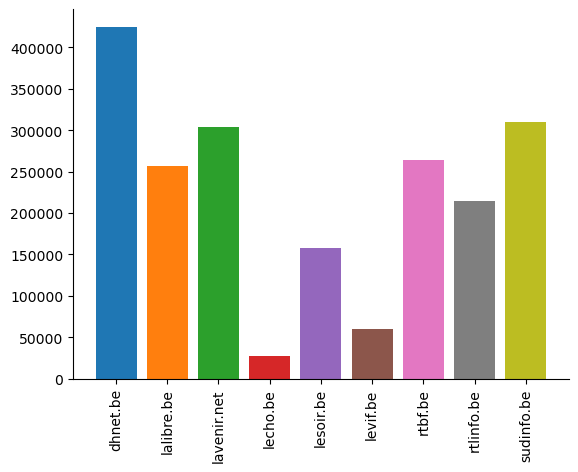

In [35]:
sources = [d["_id"] for d in results_sources_fr_sorted]
counts = [d["count"] for d in results_sources_fr_sorted]

# Liste de couleurs pour chaque source
colors = plt.cm.tab10(range(len(sources)))

# Création d'un diagramme à barres
plt.bar(sources, counts, color=colors)
#plt.title("Nombre d'articles par source")

# Personnalisation de l'axe des x
plt.xticks(rotation=90, fontsize=10)

# Personnalisation de l'axe des y
plt.yticks(fontsize=10)

# Layout du graphique
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

   #### Distribution du nombre d'articles par an et par source

In [36]:
pipeline_years_sources = [
    {
        "$match": {
            "meta.source.language": "fr",
            "date": {"$gte": datetime(2020, 5, 1)}
        }
    },
    {
        "$group": {
            "_id": {
                "year": {"$year": "$date"},
                "source": "$meta.source.name"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$group": {
            "_id": "$_id.year",
            "data": {
                "$push": {
                    "source": "$_id.source", 
                    "count": "$count"}
            }
        }
    },
    {
        "$sort": {
            "_id": 1
        }
        
    }
]

results_years_sources = list(db.aggregate(pipeline_years_sources))

In [37]:
results_years_sources_sorted = []
for result in results_years_sources:
    year_data = result["data"]
    sorted_data = sorted(year_data, key=lambda x: x["source"])
    result_sorted = {"_id": result["_id"], "data": sorted_data}
    results_years_sources_sorted.append(result_sorted)

pprint(results_years_sources_sorted)

[{'_id': 2020,
  'data': [{'count': 68036, 'source': 'dhnet.be'},
           {'count': 46879, 'source': 'lalibre.be'},
           {'count': 45642, 'source': 'lavenir.net'},
           {'count': 8454, 'source': 'lecho.be'},
           {'count': 32111, 'source': 'lesoir.be'},
           {'count': 11290, 'source': 'levif.be'},
           {'count': 46842, 'source': 'rtbf.be'},
           {'count': 62986, 'source': 'rtlinfo.be'},
           {'count': 44518, 'source': 'sudinfo.be'}]},
 {'_id': 2021,
  'data': [{'count': 114252, 'source': 'dhnet.be'},
           {'count': 59999, 'source': 'lalibre.be'},
           {'count': 80326, 'source': 'lavenir.net'},
           {'count': 11566, 'source': 'lecho.be'},
           {'count': 51068, 'source': 'lesoir.be'},
           {'count': 17706, 'source': 'levif.be'},
           {'count': 73840, 'source': 'rtbf.be'},
           {'count': 94322, 'source': 'rtlinfo.be'},
           {'count': 68179, 'source': 'sudinfo.be'}]},
 {'_id': 2022,
  'data': [{'co

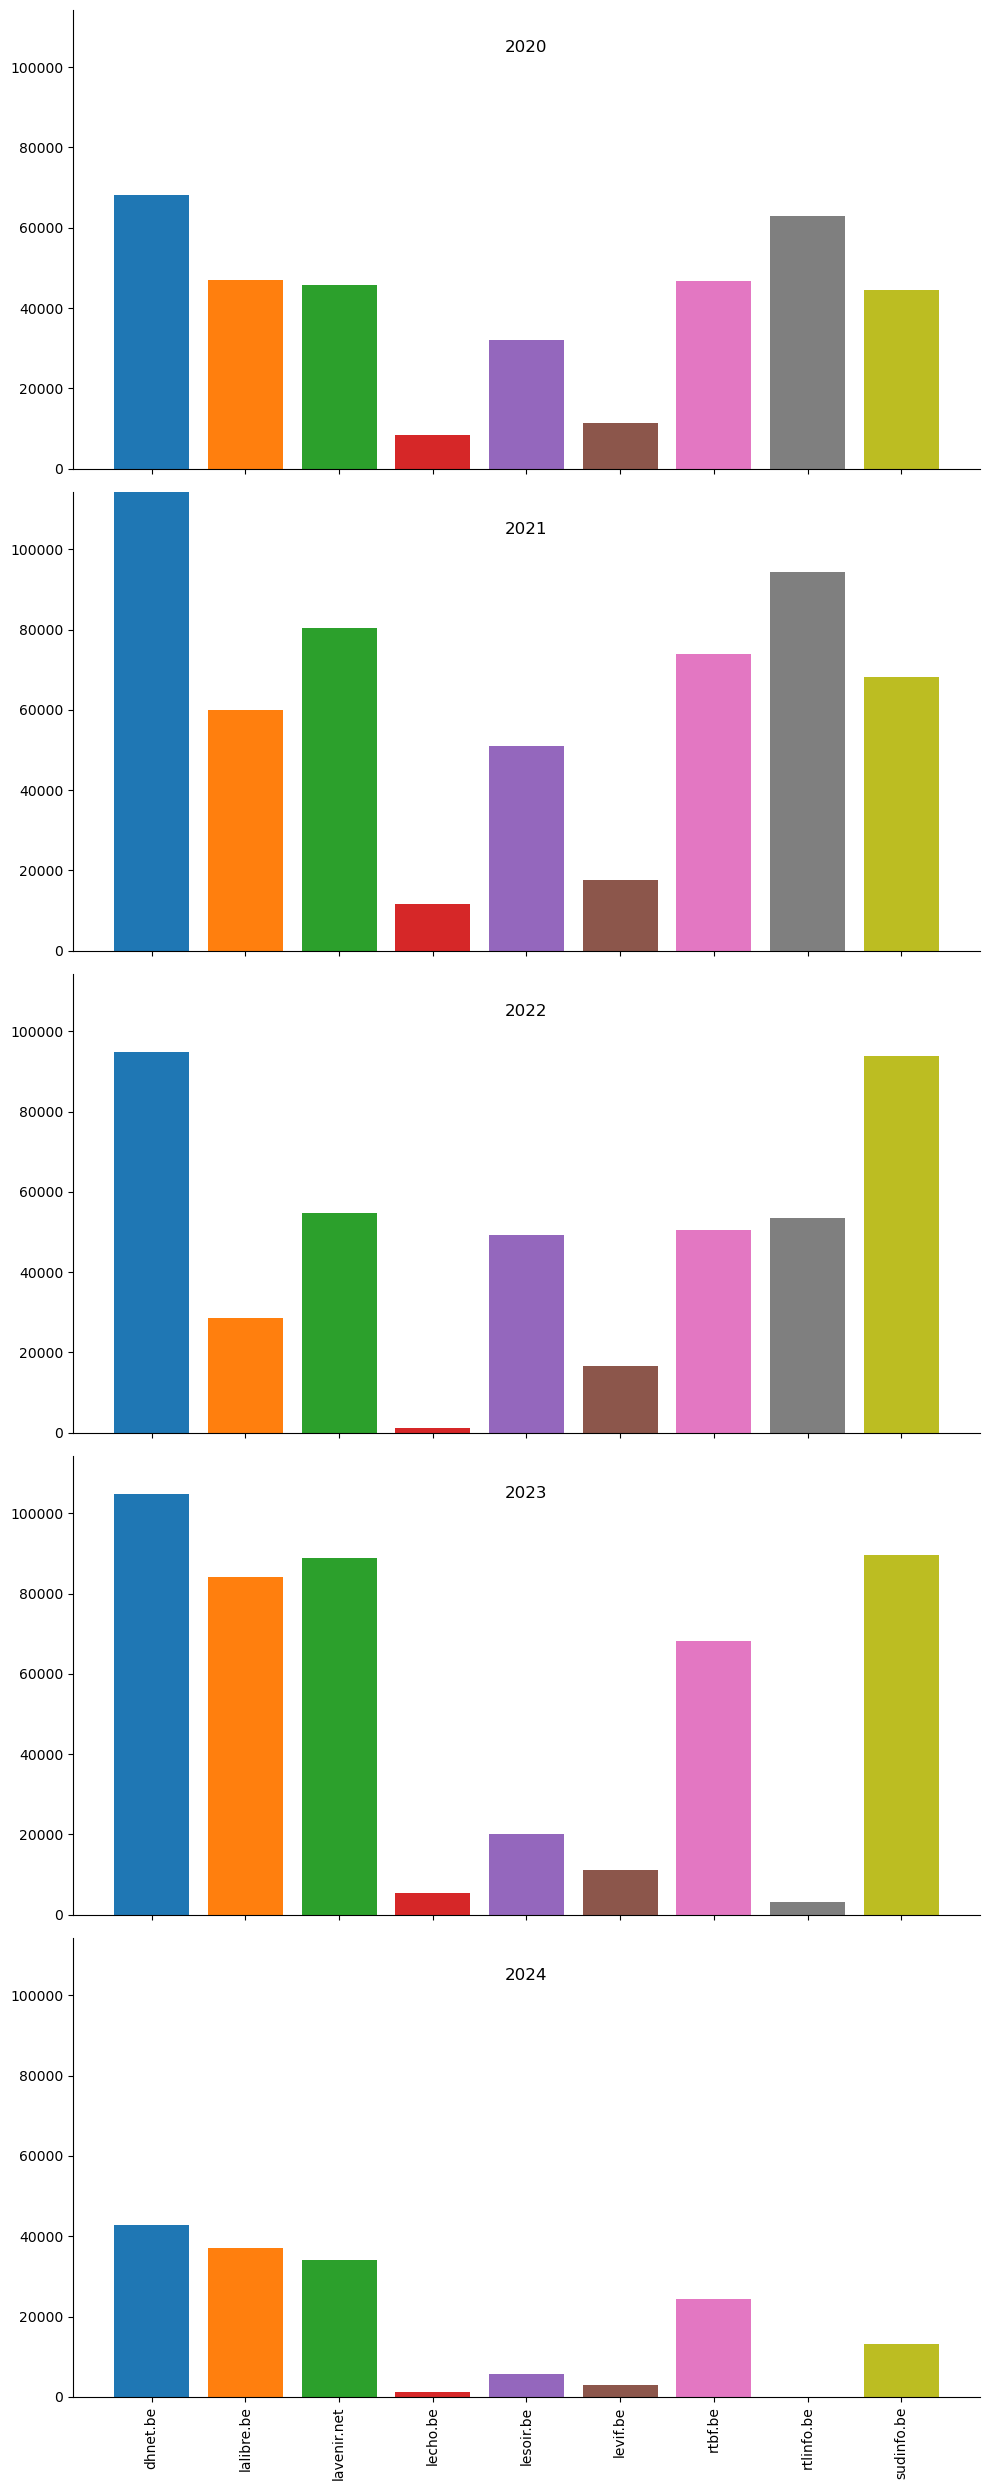

In [38]:
# Récupérer la liste des années
years = [d["_id"] for d in results_years_sources_sorted]

# Récupérer la liste complète des années
all_years = range(2020, datetime.now().year + 1)

# Créer une figure avec des sous-plots pour chaque année
fig, axs = plt.subplots(nrows=len(all_years), figsize=(10, 5*len(all_years)), sharex=True)

# Liste pour enregistrer les noms de journaux uniques
unique_sources = []

# Dictionnaire pour mapper chaque journal à une couleur spécifique
journal_colors = {}

# Valeur maximale des compteurs pour l'échelle commune
max_count = max([item["count"] for d in results_years_sources_sorted for item in d["data"]])

# Parcourir chaque année
for i, year in enumerate(all_years):
    # Récupérer les données pour l'année donnée
    data = next((d["data"] for d in results_years_sources_sorted if d["_id"] == year), [])
    
    # Si aucune donnée n'est disponible pour cette année, créer des données vides
    if not data:
        data = [{"source": source, "count": 0} for source in unique_sources]
    
    # Liste pour enregistrer les noms de journaux pour chaque année
    sources = []
    
    # Liste pour enregistrer les comptes de chaque journal pour chaque année
    counts = []
    
    # Parcourir chaque source pour l'année donnée
    for item in data:
        source = item["source"]
        count = item["count"]
        
        # Enregistrer le nom de la source pour la légende
        if source not in unique_sources:
            unique_sources.append(source)
            # Assigner une couleur unique à chaque journal
            journal_colors[source] = plt.cm.tab10(len(unique_sources) - 1)
        
        sources.append(source)
        counts.append(count)
    
    # Créer une liste de couleurs cohérente pour chaque journal
    colors = [journal_colors[source] for source in sources]
    
    # Créer une barre pour chaque journal dans le sous-plot correspondant à l'année
    axs[i].bar(sources, counts, color=colors)
    
    # Afficher les noms des journaux à l'horizontal sous l'axe des x
    axs[i].set_xticks(range(len(unique_sources)))
    axs[i].set_xticklabels(unique_sources, rotation=90, ha="center")
    
    # Supprimer la ligne supérieure et la ligne à droite
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
        
    # Définir l'échelle commune pour tous les sous-graphiques
    axs[i].set_ylim(0, max_count)

    # Ajouter les titres centrés pour chaque sous-plot
    axs[i].annotate(str(year), xy=(0.5, 1), xytext=(0, -30),  # Déplacer vers le bas (valeur négative)
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

# Ajuster les espacements entre les sous-plots
fig.tight_layout()

# Sauvegarder le graphique dans le dossier local ".\data\plots"
output_path = "./data/plots/Distribution du nombre d'articles extraits par journal et par année.png"
plt.savefig(output_path)

# Afficher le graphique
plt.show()

# Fermer la figure pour libérer la mémoire
plt.close()


#### Distribution du nombre d'articles à extraire pour la période de juin 2020 à juin 2021 inclus

Étudions maintenant la distribution du nombre d'artciles à extraire en fonction de la période que nous étudierons tout au long de l'analyse de sentiment, c'est-à-dire de juin 2020 à juin 2021 inclus.

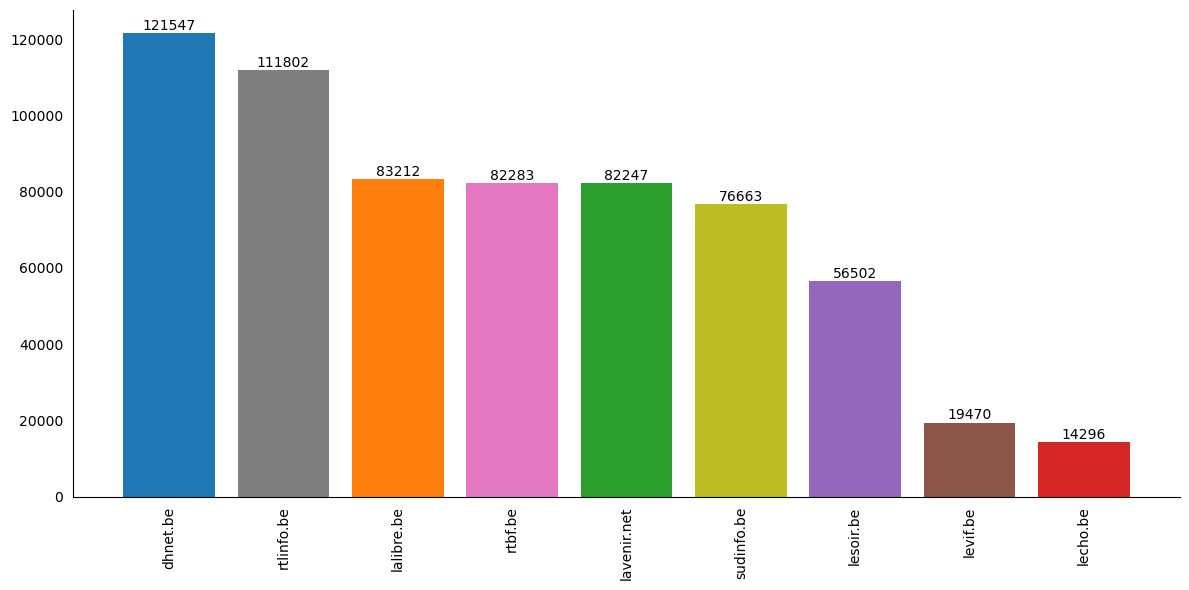

In [39]:
pipeline_years_sources = [
    {
        "$match": {
            "meta.source.language": "fr",
            "date": {
                "$gte": datetime(2020, 6, 1),
                "$lte": datetime(2021, 6, 30)
            }
        }
    },
    {
        "$group": {
            "_id": {
                "source": "$meta.source.name"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {
            "count": -1
        }
    }
]

results_years_sources = list(db.aggregate(pipeline_years_sources))

# Récupérer la liste des sources et leurs comptes
sources = [result["_id"]["source"] for result in results_years_sources]
counts = [result["count"] for result in results_years_sources]

# Récupérer les couleurs des barres du premier graphique
source_colors = [journal_colors[source] for source in unique_sources]

# Créer un graphique à barres de la distribution du nombre d'articles par source
plt.figure(figsize=(12, 6))
bars = plt.bar(sources, counts, color=[journal_colors[source] for source in sources])
#plt.xlabel("")
#plt.ylabel("")
#plt.title("")
plt.xticks(rotation=90)

# Ajouter le nombre total d'articles au-dessus de chaque barre
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, str(count), ha='center', va='bottom')

# Supprimer les axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder le graphique dans le dossier local ".\data\plots"
output_path = "./data/plots/Distribution_articles_par_source_juin2020_juin2021.png"
plt.savefig(output_path)

# Afficher le graphique
plt.show()


In [40]:
# Créer un dictionnaire pour associer les sources aux couleurs
source_color_mapping = {source: color for source, color in zip(unique_sources, source_colors)}

# Afficher le dictionnaire
print(source_color_mapping)


{'dhnet.be': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'lalibre.be': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'lavenir.net': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'lecho.be': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'lesoir.be': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'levif.be': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'rtbf.be': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'rtlinfo.be': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'sudinfo.be': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)}
